## 추천 시스템: 5종류

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/iris' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [2]:
data = np.loadtxt('./train.csv', delimiter=',', skiprows=1, dtype=np.float64)
print(data.shape)
print(type(data))
print(data[:3])

(100, 26)
<class 'numpy.ndarray'>
[[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
  0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 2.]]


In [3]:
X = data[:, 0:25]  # 독립 변수 25개
Y = data[:, 25]    # 종속 변수, 26번째, 답
print(X.shape)
print(Y.shape)
print(Y[:15])
Y = Y.astype('int')
print(Y[:15])

(100, 25)
(100,)
[0. 1. 2. 3. 4. 0. 1. 2. 3. 4. 0. 1. 2. 3. 4.]
[0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]


In [4]:
Y_encoded = to_categorical(Y) 
print(X[0])              # Iris-setosa  0  [5.1 3.5 1.4 0.2]
print('Y[0]:', Y[0])     # Y[0]의 값 0은 1 이 위치할 index로 사용 ★
print(Y_encoded[0:5])      # Y[0]의 값 0은 1 이 위치할 index로 사용 ★

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.
 0.]
Y[0]: 0
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [5]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기, 10%: 테스트
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y_encoded,
                                                        stratify=Y_encoded,
                                                        test_size=0.1,
                                                        random_state=seed)
# 나머지 데이터 90%를 분할, 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=seed)

print(y_val)
print(y_val.shape)
# Iris-setosa: 0, Iris-versicolor: 1, Iris-virginica: 2

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
(18, 5)


In [6]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed, 가중치, 편향이 일정하게 변경됨
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Dense(20, input_dim=25, activation='relu')) # 기울기 소실 방지
model.add(Dense(10, activation='relu')) # 기울기 소실 방지
model.add(Dense(5, activation='softmax')) # 0 ~ 1사이의 확률, 합 1
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

es= EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)

mcp= ModelCheckpoint(filepath='./Pinterest.h5', monitor='val_accuracy',
                    verbose=1, save_best_only=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), shuffle=True,
                epochs=100, batch_size=1, callbacks=[es, mcp])
end=time.time()
print('Runtime: {0:.0f} 초'.format(end-start))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                520       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


42/72 [================>.............] - ETA: 0s - loss: 1.3898 - accuracy: 0.2143     
Epoch 1: val_accuracy improved from -inf to 0.38889, saving model to .\Pinterest.h5
72/72 [==============================] - 1s 4ms/step - loss: 1.3088 - accuracy: 0.2500 - val_loss: 1.1295 - val_accuracy: 0.3889
Epoch 2/100
44/72 [=================>............] - ETA: 0s - loss: 1.0253 - accuracy: 0.5000    
Epoch 2: val_accuracy did not improve from 0.38889
72/72 [==============================] - 0s 2ms/step - loss: 1.0410 - accuracy: 0.4028 - val_loss: 0.8951 - val_accuracy: 0.3889
Epoch 3/100
54/72 [=====================>........] - ETA: 0s - loss: 0.8793 - accuracy: 0.6852    
Epoch 3: val_accuracy improved from 0.38889 to 0.83333, saving model to .\Pinterest.h5
72/72 [==============================] - 0s 2ms/step - loss: 0.8343 - accuracy: 0.7083 - val_loss: 0.6980 - val_accuracy: 0.8333
Epoch 4/100
41/72 [================>.............] - ETA: 0s - loss: 0.7502 - accuracy: 0.7073    
Epoch 

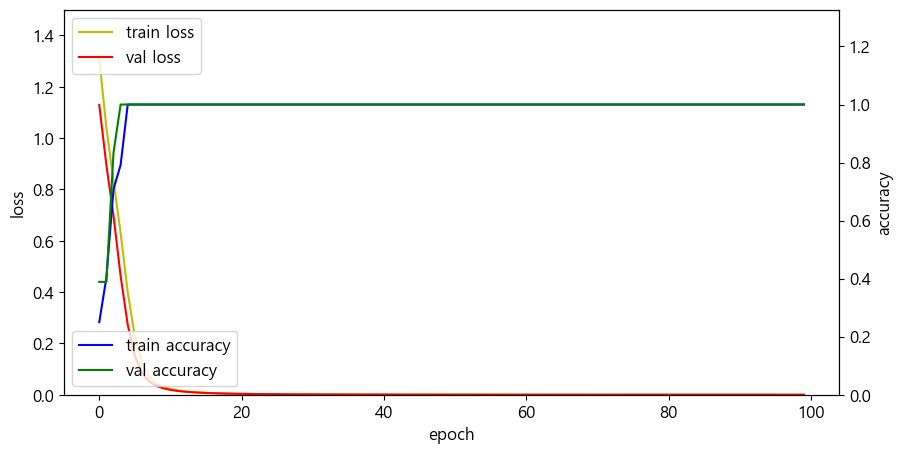

In [7]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()   # 오른쪽 y 축 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.3267]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [8]:
# verbose=0: 처리과정의 메시지 생략
test_loss, test_acc = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 2.117921394528821e-05 /정확도: 100.0 %


In [9]:
model = load_model('./Pinterest.h5')

In [10]:
# Iris-setosa: 0, Iris-versicolor: 1, Iris-virginica: 2
print('데이터:', x_test.shape) # 변수 4개 12건
p = model.predict(x_test)     # 테스트 데이터는 12건이고 3가지 확률에 속함.
print('p.shape:', p.shape)    # (12, 3): 3: 폼종의 갯수
print('데이터:', x_test[0])   # 첫번째 데이터행

데이터: (10, 25)
p.shape: (10, 5)
데이터: [0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 0.]


In [11]:
print('예측값:', p[0])       # 확률 0 ~ 1사이의 실수값
print('예측값의 합: {0:0.3f}'.format(np.sum(p[0])))
print('예측값: {0:.2f}% {1:.2f}% {2:.2f}% {3:.2f}% {4:.2f}%'.format(p[0,0]*100,p[0,1]*100,p[0,2]*100,p[0,3]*100,p[0,4]*100))
print('One-hot-encoding: ', y_test[0])
print(np.argmax(p[0]))      # 가장 큰값의 index

예측값: [0.04628957 0.01695444 0.03809656 0.88748825 0.01117123]
예측값의 합: 1.000
예측값: 4.63% 1.70% 3.81% 88.75% 1.12%
One-hot-encoding:  [0. 0. 0. 1. 0.]
3


In [12]:
print(p)

[[0.04628957 0.01695444 0.03809656 0.88748825 0.01117123]
 [0.0090791  0.6461846  0.27327323 0.04202784 0.02943519]
 [0.6499224  0.00782875 0.01280042 0.12066945 0.20877898]
 [0.00825434 0.24442565 0.71000594 0.03186703 0.00544702]
 [0.31513578 0.11863917 0.08782677 0.15214728 0.32625097]
 [0.31513578 0.11863917 0.08782677 0.15214728 0.32625097]
 [0.04628957 0.01695444 0.03809656 0.88748825 0.01117123]
 [0.6499224  0.00782875 0.01280042 0.12066945 0.20877898]
 [0.00825434 0.24442565 0.71000594 0.03186703 0.00544702]
 [0.0090791  0.6461846  0.27327323 0.04202784 0.02943519]]
